In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sb
import pickle as pkl
from braindecode.datasets import BaseConcatDataset, create_from_X_y
from shutil import copyfile
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment
from alignment import np_compute_transform_mat, np_euclidean_alignment, np_compute_target_transform_mats, np_label_alignment
from util import np_standardize

In [2]:
# data_dir = "/content/drive/MyDrive/DataVIN/Official"
# als_data_dir = "/content/drive/MyDrive/VIN_ALS"
data_dir = "../data/vin/Official"
als_data_dir = "../data/vin/Official"

In [56]:
%%time
# fmt: off
# subjects = [
#     'K300', 'K309', 'K310', 'K311', 'K312', 
#     'K313', 'K314', 'K315', 'K316', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

subjects = [
    'K001', 'K002', 'K003', 'K004',
    'K005', 'K006', 'K007', 'K008', 'K009',
    'K010', 'K011', 'K012', 'K013', 'K014',
    'K015', 'K016', 'K017', 'K018', 'K019',
    'K020', 'K021', 'K022', 'K023', 'K024',
    'K025', 'K026', 'K027', 'K028', 'K299',
    'K300', 'K301', 'K302', 'K303', 'K304',
    'K305', 'K306', 'K307', 'K308', 'K309',
    'K310', 'K311', 'K312', 'K313', 'K314',
    'K315', 'K316', 'K317', 'K319',
    'K320', 'K321', 'K322', 'K323', 'K324',
    'K325', 'K326', 'K327', 'K328', 'K329',
    'K330', 'K331', 'K332', 'K333', 'K334',
    'K335', 'K336', 'K337', 'K338', 'K339',
    'K340', 'K342', 'K343', 'K344', 'K350',
    'K351', 'K352', 'K353', 'K354', 'K355',
    'K356', 'K357', 'K358', 'K359', 'K360',
    'K361', 'K362', 'K363', 'K364', 'K365',
    'K366', 'K367', 'K368', 'K369', 'K370',
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    # "gật đầu",
    # "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
    "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    # "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
    # "O1", "Oz", "O2",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    # "nâng tay trái_Thinking": "mi",
    # "nâng tay phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    # "nâng chân trái_Thinking": "mi",
    # "nâng chân phải_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "gật đầu_Thinking": "mi",
    # "lắc đầu_Thinking": "mi",
    "há miệng_Thinking": "há miệng",
    # "há miệng_Thinking": "mi",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 3  # @param
# window_duration = 6  # @param
# window_stride_duration = 3  # @param
window_duration = 2
window_stride_duration = 0.5

fmin = 4.0  # @param
fmax = 40.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

# als_ds = load_data(
#     als_data_dir,  
#     subjects=als_subjects,
#     scenarios=scenarios,
#     events=events,
#     channels=channels,
#     label_mapping=label_mapping,
#     minimal_trial_duration=minimal_trial_duration,
#     window_duration=window_duration, 
#     window_stride_duration=window_stride_duration, 
#     start_offset=0,
#     stop_offset=0,
#     fmin=fmin, 
#     fmax=fmax, 
#     moving_standardize=False,
#     resample=None,
#     return_raw=False,
#     return_preprocessed=False,
#     preload=True,
# )

# ds = BaseConcatDataset([ds, als_ds])

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "K314":
#         _ds_info["subject"] = "K314_t1"
#     elif _ds_info["subject"] == "K324":
#         _ds_info["subject"] = "K314_t2"

ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 32 channels


subject:  11%|█         | 12/109 [00:00<00:00, 118.82it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  22%|██▏       | 24/109 [00:00<00:02, 32.14it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  28%|██▊       | 31/109 [00:00<00:02, 31.13it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:211: RuntimeWarning: Limited 1 annotation(s

loaded 96 subjects - 34836 epochs
CPU times: user 1min 34s, sys: 9.02 s, total: 1min 43s
Wall time: 1min 44s


subject        scenario                event           label  trial  \
0       K001   nâng tay trái             Thinking   nâng tay trái      0   
1       K001   nâng tay trái              Resting            rest      0   
2       K001   nâng tay trái  Thinking and Acting   nâng tay trái      0   
3       K001   nâng tay trái              Resting            rest      1   
4       K001   nâng tay trái             Thinking   nâng tay trái      1   
...      ...             ...                  ...             ...    ...   
3703    K375  nâng chân phải              Resting            rest      3   
3704    K375  nâng chân phải             Thinking  nâng chân phải      2   
3705    K375  nâng chân phải              Resting            rest      4   
3706    K375  nâng chân phải  Thinking and Acting  nâng chân phải      2   
3707    K375  nâng chân phải              Resting            rest      5   

      split  epochs  
0     train       9  
1     train      10  
2     train      22  
3     train       5  
4     train      10  
...     ...     ...  
3703  train       5  
3704  train      11  
3705  train       6  
3706  train       9  
3707  train       3  

[3708 rows x 7 columns]

In [4]:
target_subject = "K309"

list_of_ds = list()
for _ds in ds.datasets:
    if _ds.description["subject"] == target_subject:
        list_of_ds.append(_ds)
        
subject_ds = BaseConcatDataset(list_of_ds)

In [5]:
subject_ds_info = subject_ds.description
subject_ds_info

subject        scenario                event           label  trial  split
0     K309   nâng tay trái             Thinking   nâng tay trái      0  train
1     K309   nâng tay trái              Resting            rest      0  train
2     K309   nâng tay trái  Thinking and Acting   nâng tay trái      0  train
3     K309   nâng tay trái              Resting            rest      1  train
4     K309   nâng tay trái             Thinking   nâng tay trái      1  train
5     K309   nâng tay trái              Resting            rest      2  train
6     K309   nâng tay trái  Thinking and Acting   nâng tay trái      1  train
7     K309   nâng tay trái              Resting            rest      3  train
8     K309   nâng tay trái             Thinking   nâng tay trái      2  train
9     K309   nâng tay trái              Resting            rest      4  train
10    K309   nâng tay trái  Thinking and Acting   nâng tay trái      2  train
11    K309   nâng tay trái              Resting            rest      5  train
12    K309   nâng tay phải             Thinking   nâng tay phải      0  train
13    K309   nâng tay phải              Resting            rest      0  train
14    K309   nâng tay phải  Thinking and Acting   nâng tay phải      0  train
15    K309   nâng tay phải              Resting            rest      1  train
16    K309   nâng tay phải             Thinking   nâng tay phải      1  train
17    K309   nâng tay phải              Resting            rest      2  train
18    K309   nâng tay phải  Thinking and Acting   nâng tay phải      1  train
19    K309   nâng tay phải              Resting            rest      3  train
20    K309   nâng tay phải             Thinking   nâng tay phải      2  train
21    K309   nâng tay phải              Resting            rest      4  train
22    K309   nâng tay phải  Thinking and Acting   nâng tay phải      2  train
23    K309   nâng tay phải              Resting            rest      5  train
24    K309  nâng chân trái             Thinking  nâng chân trái      0  train
25    K309  nâng chân trái              Resting            rest      0  train
26    K309  nâng chân trái  Thinking and Acting  nâng chân trái      0  train
27    K309  nâng chân trái              Resting            rest      1  train
28    K309  nâng chân trái             Thinking  nâng chân trái      1  train
29    K309  nâng chân trái              Resting            rest      2  train
30    K309  nâng chân trái  Thinking and Acting  nâng chân trái      1  train
31    K309  nâng chân trái              Resting            rest      3  train
32    K309  nâng chân trái             Thinking  nâng chân trái      2  train
33    K309  nâng chân trái              Resting            rest      4  train
34    K309  nâng chân trái  Thinking and Acting  nâng chân trái      2  train
35    K309  nâng chân trái              Resting            rest      5  train
36    K309  nâng chân phải             Thinking  nâng chân phải      0  train
37    K309  nâng chân phải              Resting            rest      0  train
38    K309  nâng chân phải  Thinking and Acting  nâng chân phải      0  train
39    K309  nâng chân phải              Resting            rest      1  train
40    K309  nâng chân phải             Thinking  nâng chân phải      1  train
41    K309  nâng chân phải              Resting            rest      2  train
42    K309  nâng chân phải  Thinking and Acting  nâng chân phải      1  train
43    K309  nâng chân phải              Resting            rest      3  train
44    K309  nâng chân phải             Thinking  nâng chân phải      2  train
45    K309  nâng chân phải              Resting            rest      4  train
46    K309  nâng chân phải  Thinking and Acting  nâng chân phải      2  train
47    K309  nâng chân phải              Resting            rest      5  train

In [6]:
epochs = defaultdict(list)
for i, r in subject_ds_info.iterrows():
    epochs[f"{r['label']}_{r['event']}"].append(subject_ds.datasets[i].windows)
    
for k, v in epochs.items():
    epochs[k] = mne.concatenate_epochs(v)

nâng tay trái_Thinking


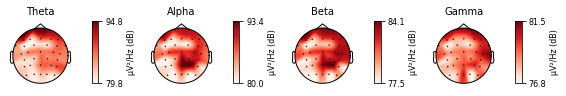

rest_Resting


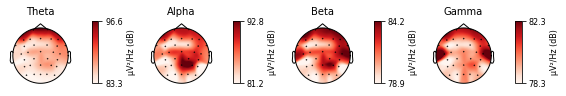

nâng tay trái_Thinking and Acting


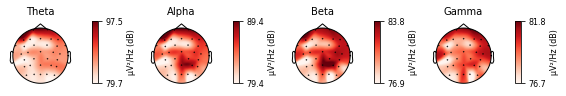

nâng tay phải_Thinking


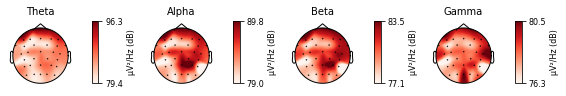

nâng tay phải_Thinking and Acting


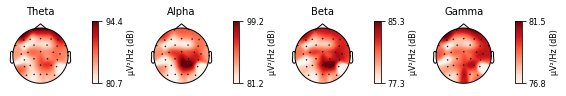

nâng chân trái_Thinking


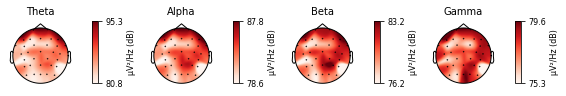

nâng chân trái_Thinking and Acting


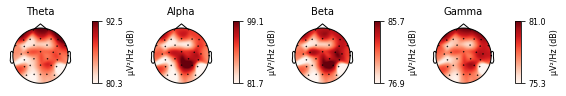

nâng chân phải_Thinking


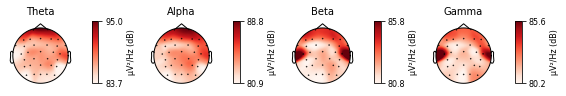

nâng chân phải_Thinking and Acting


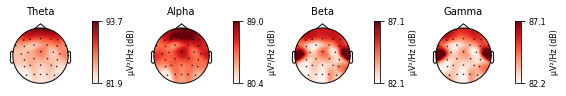

In [7]:
for k, v in epochs.items():
    print(k)
    v.plot_psd_topomap(bands=[(4, 8, "Theta"), (8, 12, "Alpha"), (12, 30, "Beta"), (30, 40, "Gamma")])

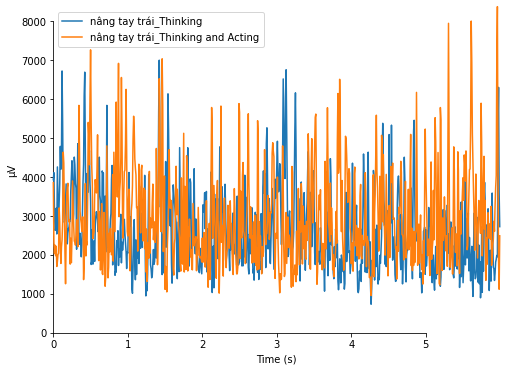

[<Figure size 576x432 with 1 Axes>]

In [357]:
mne.viz.plot_compare_evokeds({k: epochs[k].average() for k in ["nâng tay trái_Thinking", "nâng tay trái_Thinking and Acting"]})

In [12]:
plt.rcParams["figure.figsize"] = (15,5)

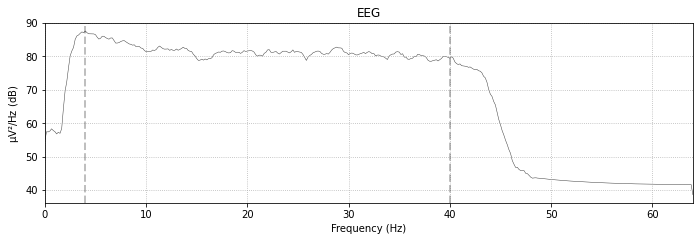

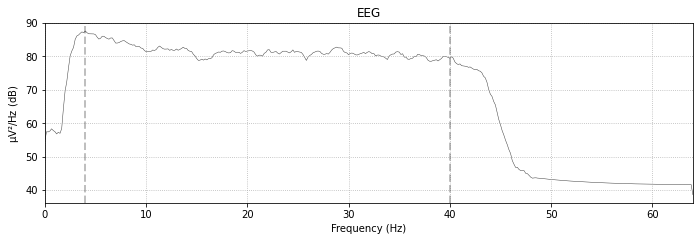

In [13]:
epochs["nâng chân phải_Thinking"].plot_psd(picks=["Oz"])

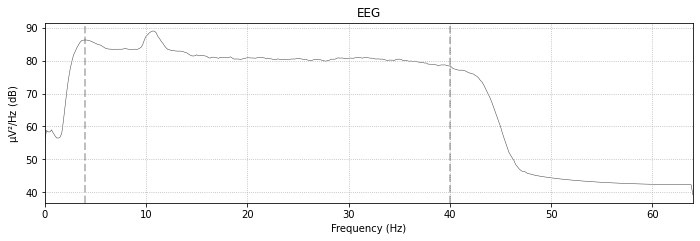

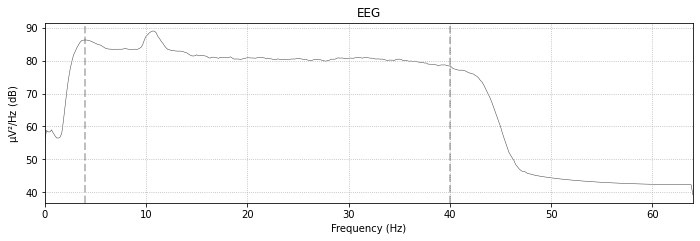

In [14]:
epochs["rest_Resting"].plot_psd(picks=["Oz"])

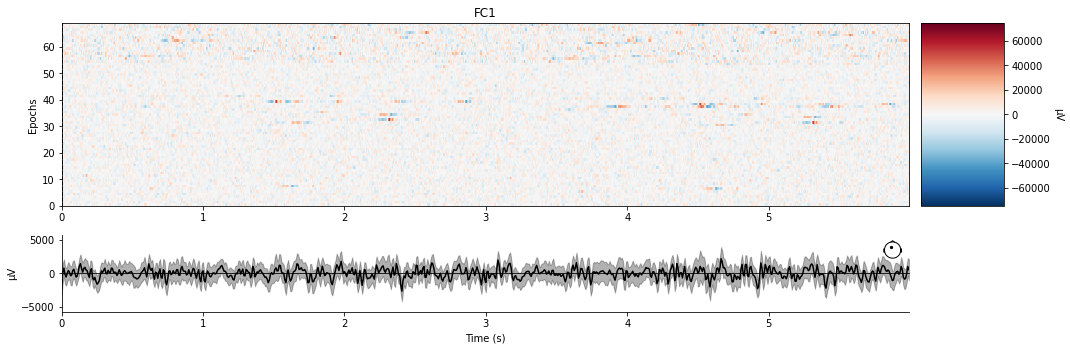

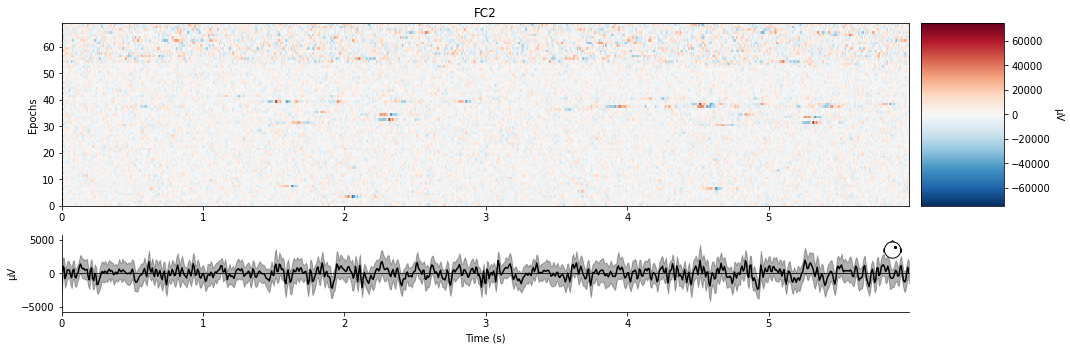

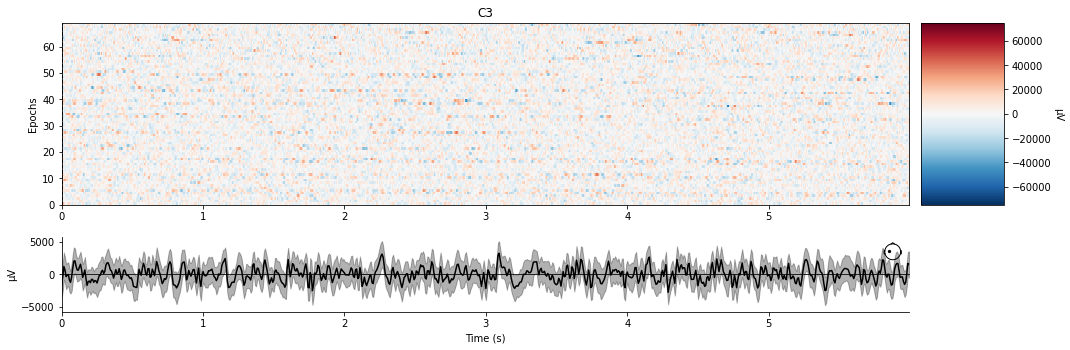

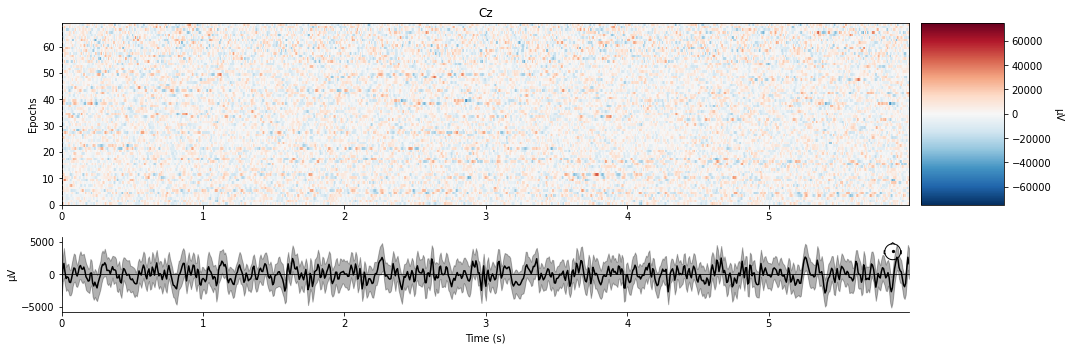

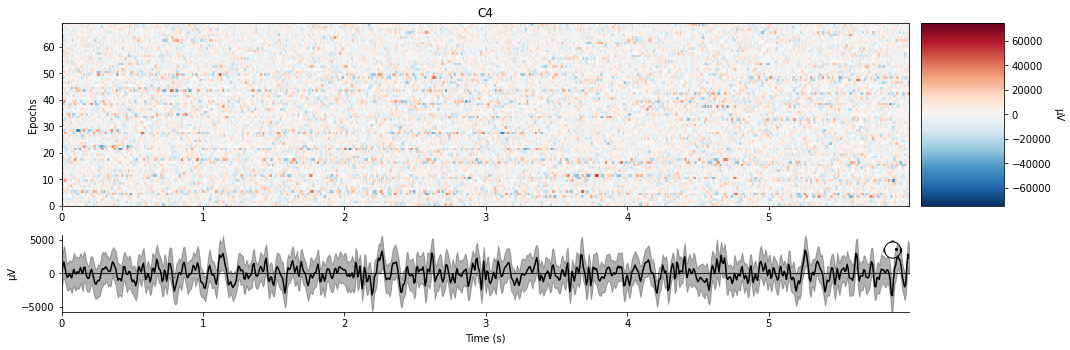

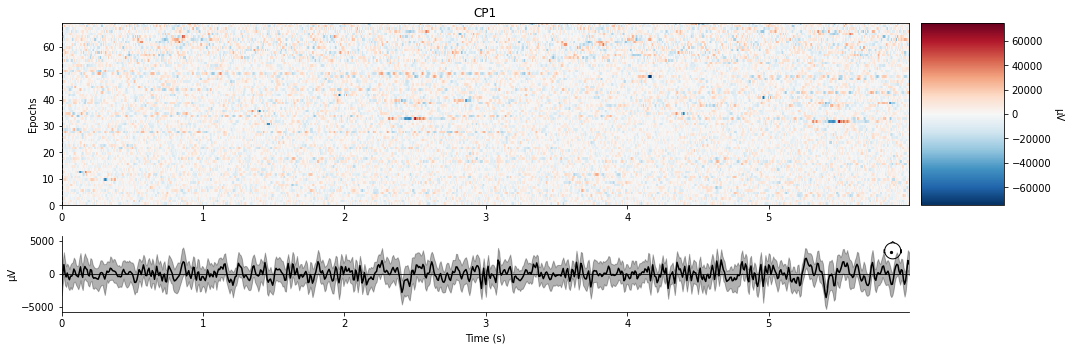

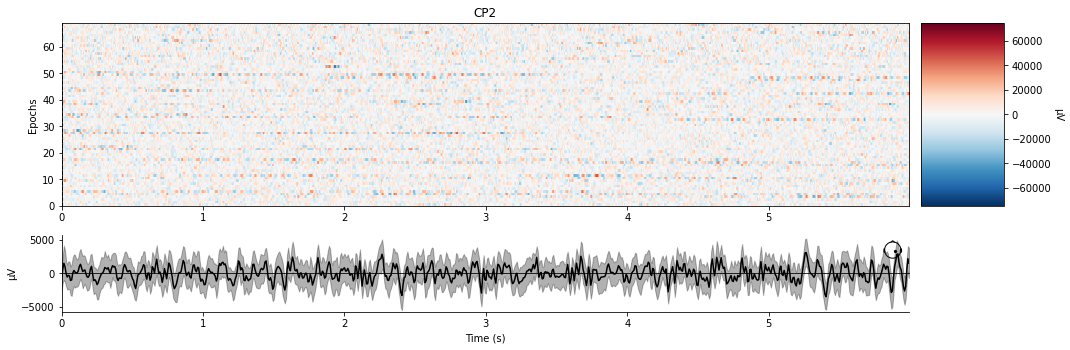

[<Figure size 1080x360 with 4 Axes>,
 <Figure size 1080x360 with 4 Axes>,
 <Figure size 1080x360 with 4 Axes>,
 <Figure size 1080x360 with 4 Axes>,
 <Figure size 1080x360 with 4 Axes>,
 <Figure size 1080x360 with 4 Axes>,
 <Figure size 1080x360 with 4 Axes>]

In [17]:
epochs["rest_Resting"].plot_image(picks=["FC3", "FC1", "FC2", "FC4", "C3", "Cz", "C4", "CP3", "CP1", "CP2", "CP4"])

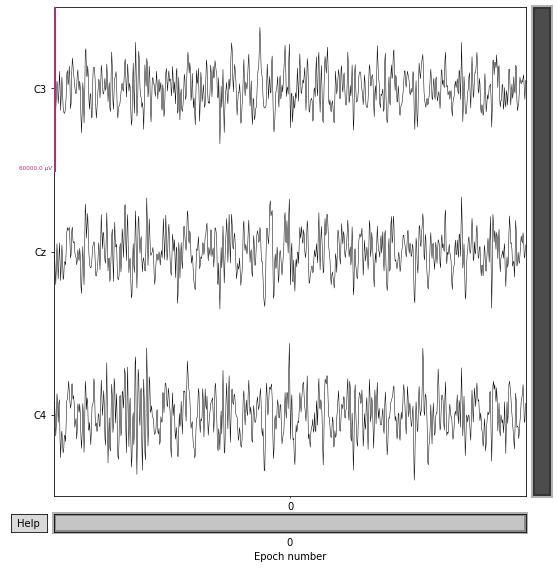

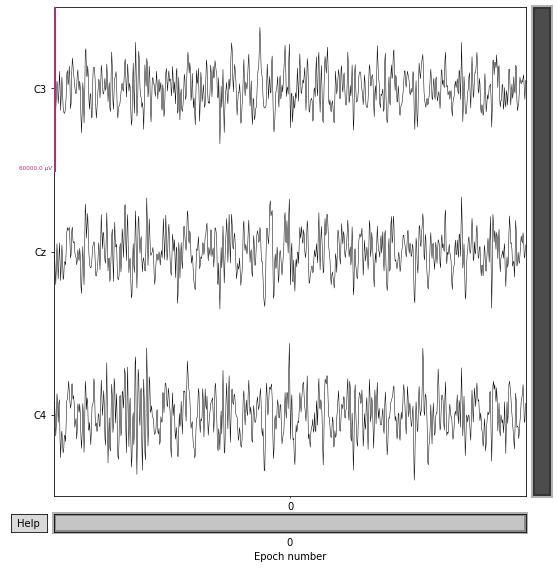

In [50]:
epochs["nâng tay phải_Thinking and Acting"][0].plot(picks=["C3", "Cz", "C4"], scalings={"eeg": 0.03})

In [19]:
from mne.time_frequency import psd_multitaper, psd_welch, tfr_multitaper

In [43]:
freq_range = np.arange(4, 40)

power = mne.time_frequency.tfr_multitaper(epochs["nâng chân phải_Thinking"][1], freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                          return_itc=False, average=True, decim=2)

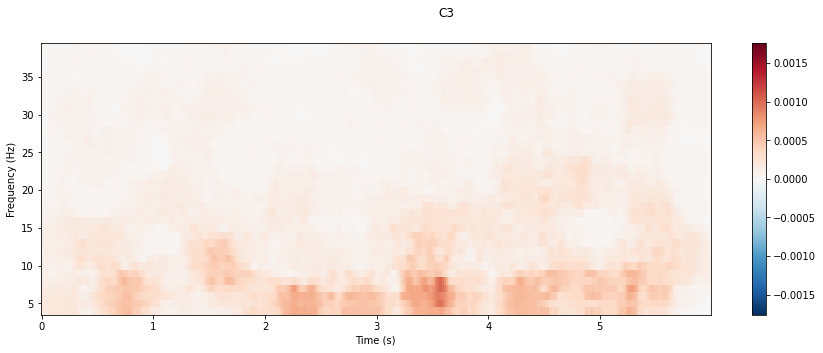

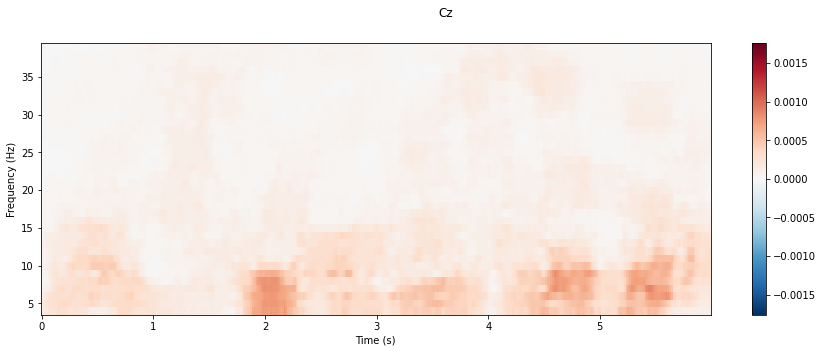

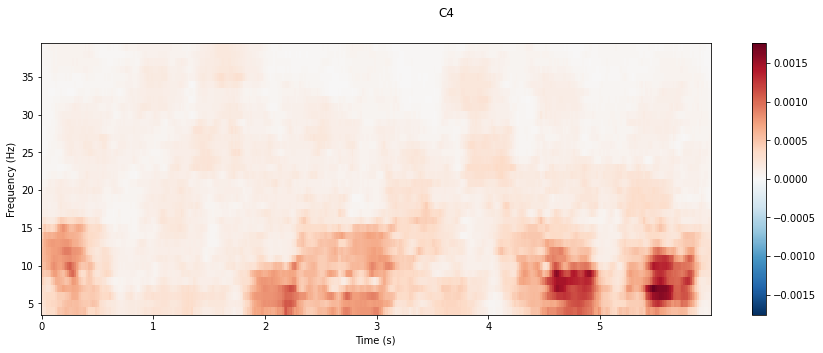

[<Figure size 1080x360 with 2 Axes>,
 <Figure size 1080x360 with 2 Axes>,
 <Figure size 1080x360 with 2 Axes>]

In [44]:
power.plot(picks=["C3", "Cz", "C4"], title="auto", mode="logratio")

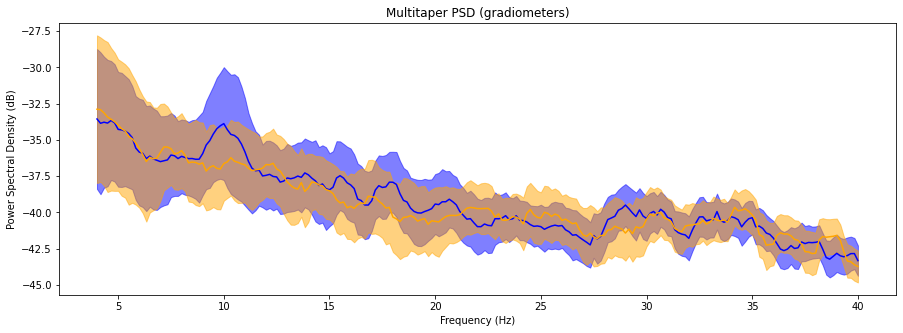

In [54]:
f, ax = plt.subplots()
psds, freqs = psd_multitaper(epochs["nâng tay trái_Thinking"], fmin=4, fmax=40, n_jobs=1)
psds = 10 * np.log10(psds)  # convert to dB
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='b')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='b', alpha=.5)

psds, freqs = psd_multitaper(epochs["nâng tay trái_Thinking and Acting"], fmin=4, fmax=40, n_jobs=1)
psds = 10 * np.log10(psds)  # convert to dB
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='orange')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='orange', alpha=.5)

ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

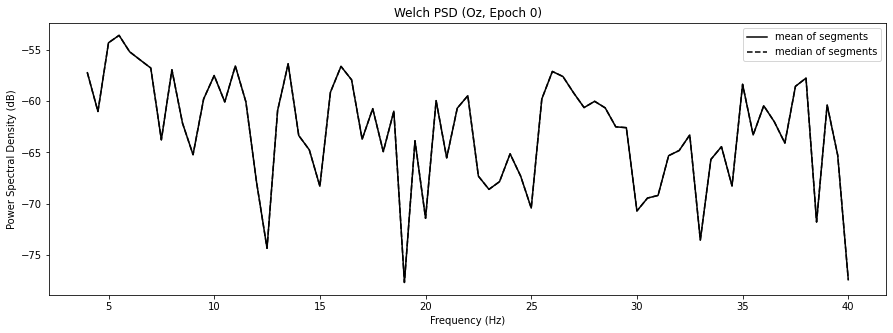

In [85]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=4, fmax=40, n_jobs=1)
psds_welch_mean, freqs_mean = psd_welch(epochs["nâng tay phải_Thinking and Acting"], average='mean', **kwargs)
psds_welch_median, freqs_median = psd_welch(epochs["nâng tay phải_Thinking and Acting"], average='median', **kwargs)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = 'Oz'
ch_idx = epochs["nâng tay phải_Thinking"].info['ch_names'].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(freqs_mean, psds_welch_mean[epo_idx, ch_idx, :], color='k',
        ls='-', label='mean of segments')
ax.plot(freqs_median, psds_welch_median[epo_idx, ch_idx, :], color='k',
        ls='--', label='median of segments')

ax.set(title='Welch PSD ({}, Epoch {})'.format(ch_name, epo_idx),
       xlabel='Frequency (Hz)', ylabel='Power Spectral Density (dB)')
ax.legend(loc='upper right')
plt.show()

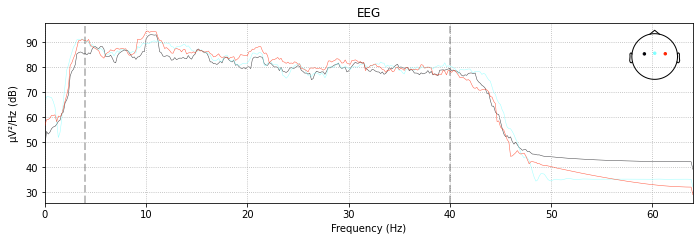

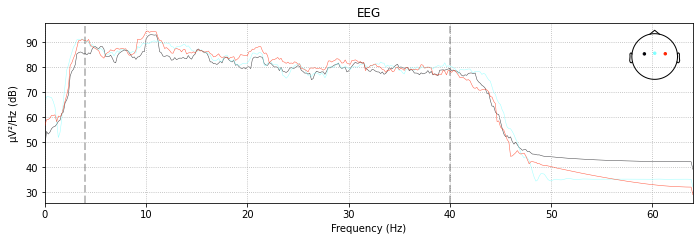

In [121]:
epochs["nâng tay trái_Thinking"][0].plot_psd(picks=["C3", "Cz", "C4"])

In [118]:
epochs["nâng tay trái_Thinking"]

<Epochs |  9 events (all good), 0 - 5.99219 sec, baseline off, ~1.7 MB, data loaded, with metadata,
 'nâng chân phải': 0
 'nâng chân trái': 0
 'nâng tay phải': 0
 'nâng tay trái': 9
 'rest': 0>

In [229]:
freq_range = np.arange(4, 40)

power = mne.time_frequency.tfr_multitaper(epochs["rest_Resting"][2], freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                          return_itc=False, average=True, decim=2)

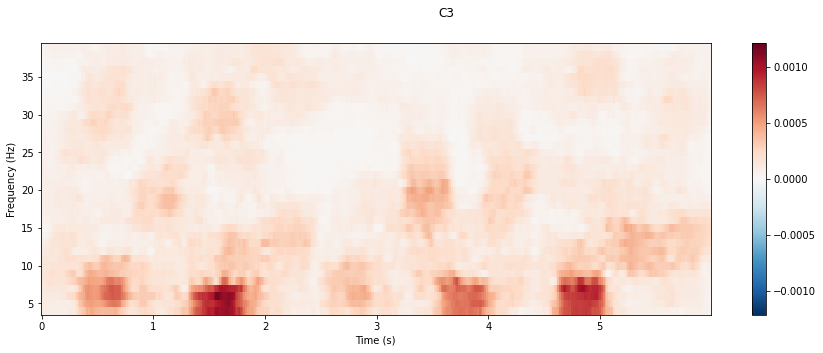

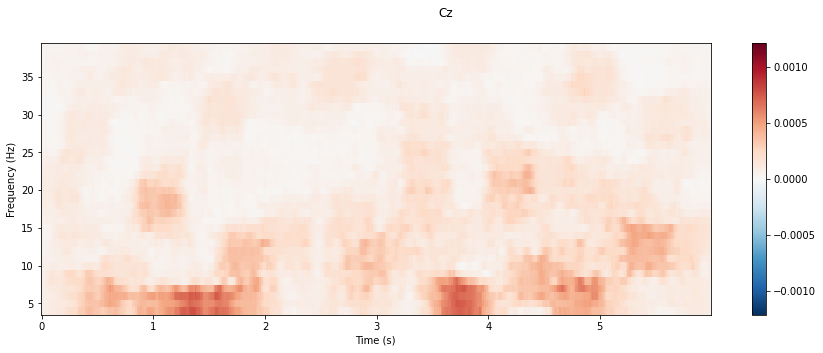

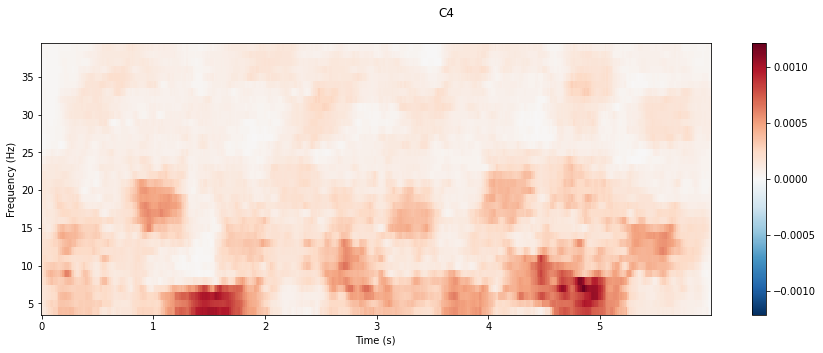

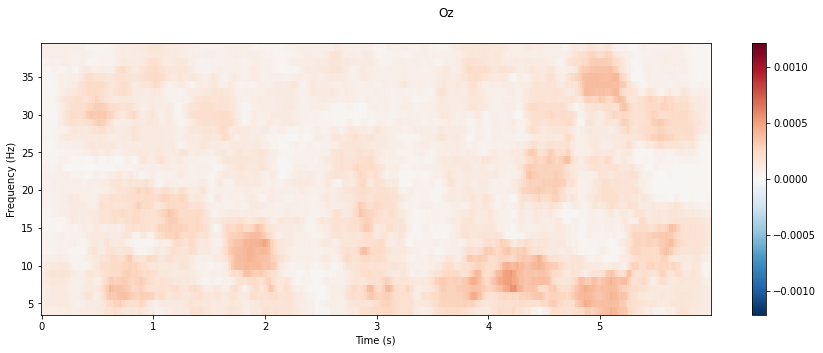

[<Figure size 1080x360 with 2 Axes>,
 <Figure size 1080x360 with 2 Axes>,
 <Figure size 1080x360 with 2 Axes>,
 <Figure size 1080x360 with 2 Axes>]

In [230]:
power.plot(picks=["C3", "Cz", "C4", "Oz"], title="auto", mode="logratio")

In [299]:
!cat ../data/vin/Official/K309/sample2/eeg.json

{"Scenario": "N\u00e2ng tay ph\u1ea3i", "SamplingFrequence": 128, "EEGchannelNumber": 32}

In [300]:
raw = mne.io.read_raw_edf("../data/vin/Official/K309/sample2/EEG.edf", preload=True)
raw = raw.pick_channels(channels, ordered=True)
raw.set_montage("standard_1005")
raw = raw.filter(4, 40)

In [301]:
anno = pd.DataFrame(raw.annotations)
anno

onset  duration          description                 orig_time
0    9.6537    6.5470             Thinking 2021-10-18 16:14:55+00:00
1   16.2016    6.2142              Resting 2021-10-18 16:14:55+00:00
2   22.4158    6.7635  Thinking and Acting 2021-10-18 16:14:55+00:00
3   29.1802    5.2810              Resting 2021-10-18 16:14:55+00:00
4   34.4612    6.3656             Thinking 2021-10-18 16:14:55+00:00
5   40.8268    7.2978              Resting 2021-10-18 16:14:55+00:00
6   48.1246    7.6961  Thinking and Acting 2021-10-18 16:14:55+00:00
7   55.8217    6.3306              Resting 2021-10-18 16:14:55+00:00
8   62.1533    6.9969             Thinking 2021-10-18 16:14:55+00:00
9   69.1512    6.8631              Resting 2021-10-18 16:14:55+00:00
10  76.0153    7.4804  Thinking and Acting 2021-10-18 16:14:55+00:00
11  83.4957    6.1810              Resting 2021-10-18 16:14:55+00:00
12  89.6777   43.9202               Typing 2021-10-18 16:14:55+00:00

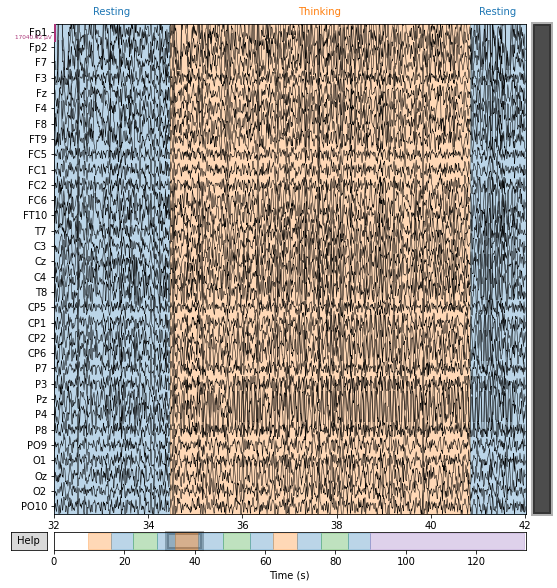

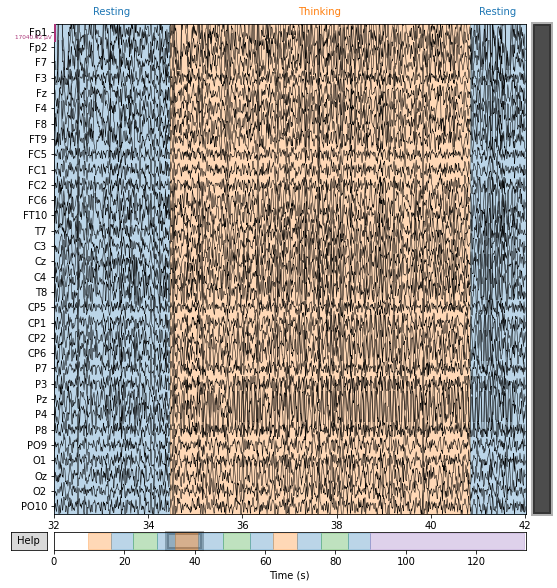

In [302]:
raw.plot(scalings="auto", n_channels=32, start=32, duration=10)

In [303]:
events, event_id = mne.events_from_annotations(raw)
events

array([[ 1236,     0,     2],
       [ 2074,     0,     1],
       [ 2869,     0,     3],
       [ 3735,     0,     1],
       [ 4411,     0,     2],
       [ 5226,     0,     1],
       [ 6160,     0,     3],
       [ 7145,     0,     1],
       [ 7956,     0,     2],
       [ 8851,     0,     1],
       [ 9730,     0,     3],
       [10687,     0,     1],
       [11479,     0,     4]])

In [304]:
event_id

{'Resting': 1, 'Thinking': 2, 'Thinking and Acting': 3, 'Typing': 4}

In [339]:
e = mne.Epochs(raw, events=events, event_id=event_id, tmin=-3, tmax=1, baseline=(0, 0))
e

<Epochs |  13 events (good & bad), -3 - 1 sec, baseline 0 – 0 sec, ~49 kB, data not loaded,
 'Resting': 6
 'Thinking': 3
 'Thinking and Acting': 3
 'Typing': 1>

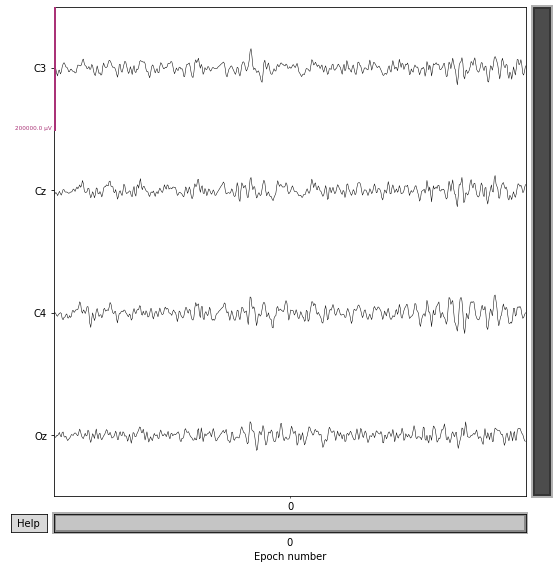

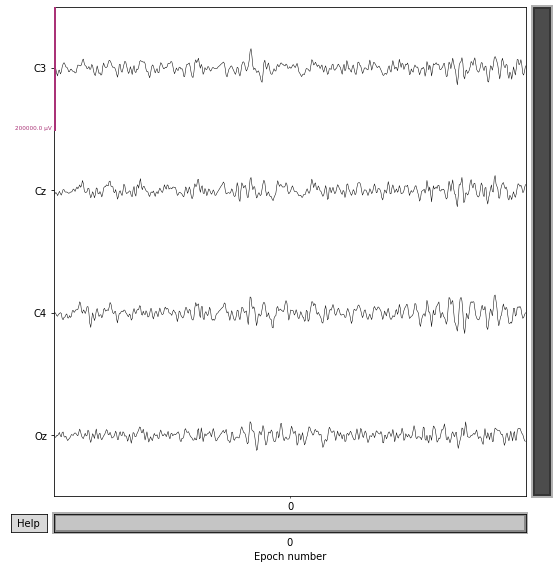

In [340]:
e[0].plot(picks=["C3", "Cz", "C4", "Oz"], scalings={"eeg": 0.1}, n_channels=4)

In [341]:
freq_range = np.arange(4, 40)

power = mne.time_frequency.tfr_multitaper(e["Thinking"], freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                          return_itc=False, average=True, decim=2)

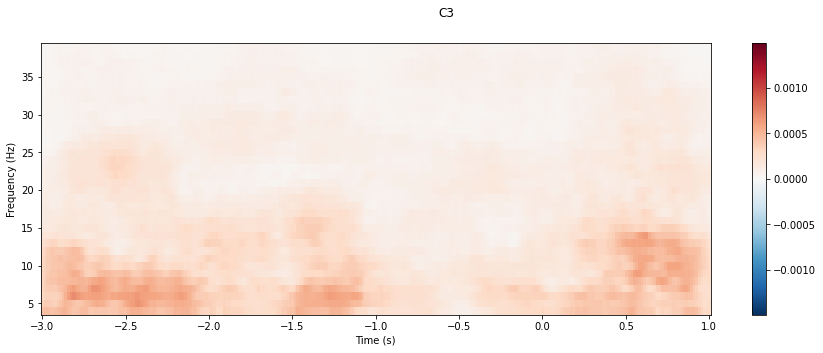

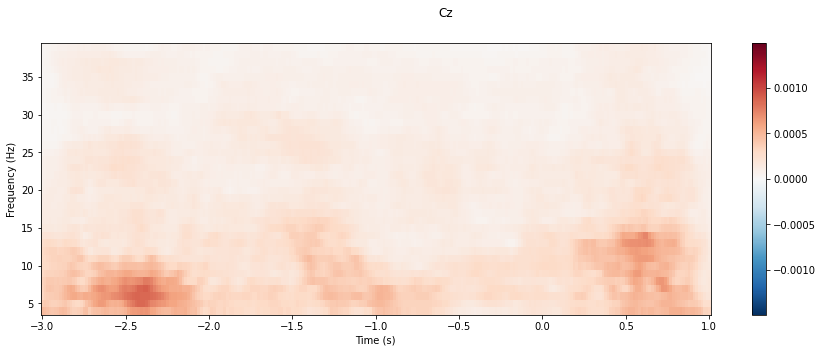

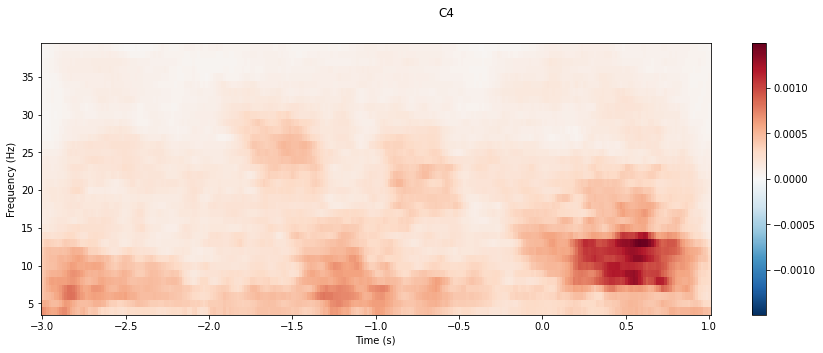

[<Figure size 1080x360 with 2 Axes>,
 <Figure size 1080x360 with 2 Axes>,
 <Figure size 1080x360 with 2 Axes>]

In [342]:
power.plot(picks=["C3", "Cz", "C4"], title="auto", mode="logratio")

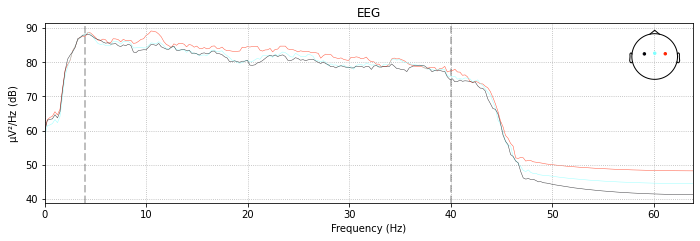

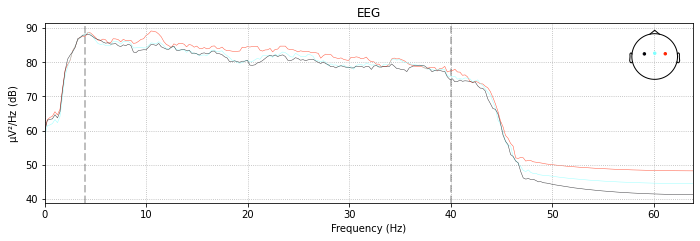

In [344]:
e["Thinking"].plot_psd(picks=["C3", "Cz", "C4"])

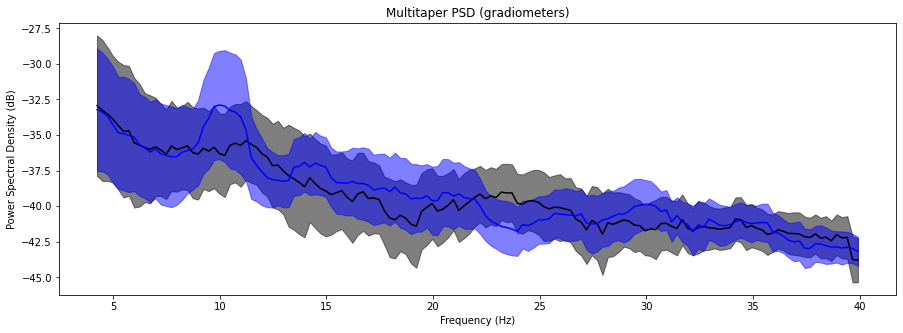

In [348]:
f, ax = plt.subplots()
psds, freqs = psd_multitaper(e["Thinking"], fmin=4, fmax=40, n_jobs=1)
psds = 10 * np.log10(psds)  # convert to dB
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)

psds, freqs = psd_multitaper(e["Resting"], fmin=4, fmax=40, n_jobs=1)
psds = 10 * np.log10(psds)  # convert to dB
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='b')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='b', alpha=.5)

ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

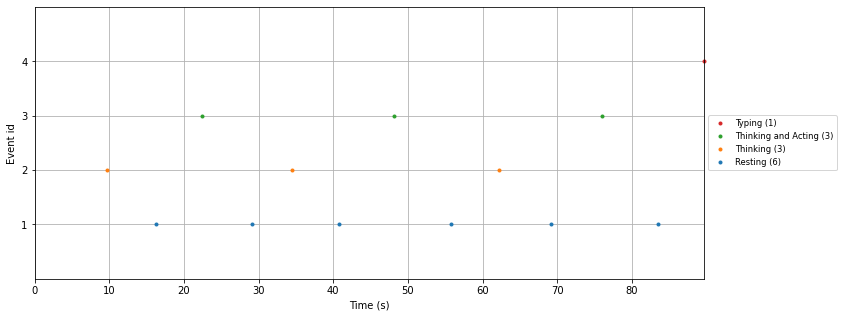

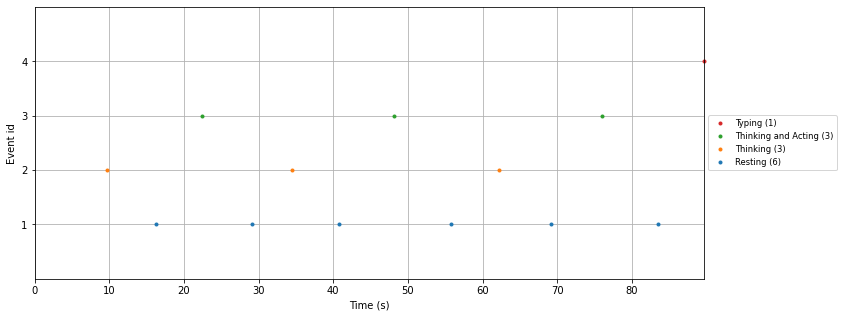

In [364]:
mne.viz.plot_events(events, event_id=event_id, sfreq=128.0, first_samp=raw.first_samp)